In [ ]:
import pandas as pd
housing=pd.read_csv("housing.csv")

## 1. Pick some instances randomly
Typically 20% of the dataset or less if dataset is large.

In [ ]:
import numpy as np

def shuffle_and_split_data(data,test_ratio):
  shuffled_indices=np.random.permutation(len(data))
  test_set_size=int(len(data)*test_ratio)
  test_indices=shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return data.iloc[train_indices],data.iloc[test_indices]

In [ ]:
train_set,test_set=shuffle_and_split_data(housing,0.2)
print(len(train_set),len(test_set))

16512 4128


## Whats wrong here ?

If we run the program again, it will generate a different test set. Over time algo will get to see the whole dataset, which we want to avoid.

## Solutions :
1. Save the test set on the first run and load it in subsequent runs.
2. Set random number generator's seed before calling np.random.permutation so that it will generate same shuffled indices every time. np.random.seed(42)

## Whats wrong again ??

It will break next time when you fetch an updated dataset.


# 2. Use hash value

Use instance's unique and immutable identifiers to decide whether or not it should go in the test set. Compute hash value of each instance's identifier and put in the test set if its lower than or equal to 20% of maximum hash value. Test set will be consistent and new test set will contain 20% of new instances.

In [ ]:
from zlib import crc32

def is_id_in_test_set(identifier,test_ratio):
  return crc32(np.int64(identifier)) < test_ratio* 2**32

def split_data_with_id_hash(data,test_ratio,id_column):
  ids=data[id_column]
  in_test_set=ids.apply(lambda id_:is_id_in_test_set(id_,test_ratio))
  return data.loc[~in_test_set],data.loc[in_test_set]

In [ ]:
## If there's no identifier column, we can use row index as id.
## Only conditions are no rows gets deleted and new rows gets appended to the end.

housing_with_id=housing.reset_index()
train_set,test_set=split_data_with_id_hash(housing_with_id,0.2,"index")

In [ ]:
print(len(train_set),len(test_set))

16512 4128


In [ ]:
## If conditions are not guaranteed to met, unique identiifer can be built using most stable features.
housing_with_id["id"]=housing["longitude"]*1000 + housing["latitude"]
train_set,test_set=split_data_with_id_hash(housing_with_id,0.2,"id")
print(len(train_set),len(test_set))

16322 4318


# 3. Scikit-Learn
-> Function

   train_test_split()

-> Splitter classes

  StratifiedShuffleSplit()

  .split() method yields the training and test indices not the data itself.



In [ ]:
from sklearn.model_selection import train_test_split
train_set,test_set=train_test_split(housing,test_size=0.2,random_state=42)
print(len(train_set),len(test_set))

16512 4128


Above all are random sampling methods. This is fine if dataset is large enough relative to number of attributes otherwise there's a risk of introducing a significant sampling bias.

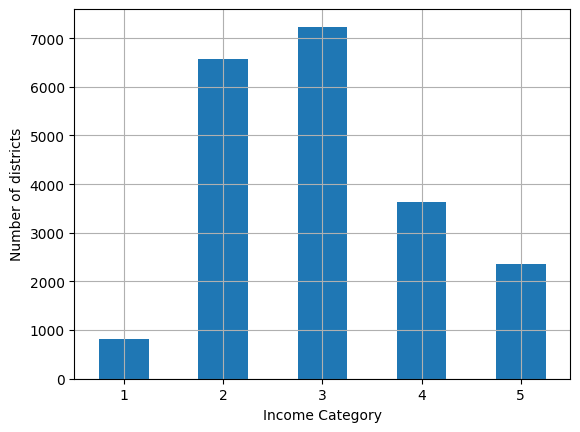

In [ ]:
import matplotlib.pyplot as plt

housing["income_cat"]=pd.cut(housing["median_income"],bins=[0.,1.5,3.0,4.5,6.,np.inf],labels=[1,2,3,4,5])
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0,grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter=StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=42)
strat_splits=[]
for train_index,test_index in splitter.split(housing,housing["income_cat"]):
  strat_train_set_n=housing.iloc[train_index]
  strat_test_set_n=housing.iloc[test_index]
  strat_splits.append([strat_train_set_n,strat_test_set_n])

strat_train_set,strat_test_set=strat_splits[0]
print(len(strat_train_set),len(strat_test_set))

16512 4128


In [ ]:
strat_train_set,strat_test_set=train_test_split(housing,test_size=0.2,stratify=housing["income_cat"],random_state=42)
print(len(strat_train_set),len(strat_test_set))

16512 4128


In [ ]:
strat_test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN,5
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,<1H OCEAN,4
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,NEAR OCEAN,3
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,NEAR OCEAN,3
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,187500.0,NEAR BAY,3


In [ ]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [ ]:
housing["income_cat"].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

# Note on Sampling methods

**Probability sampling methods**

Probability sampling means every member of population has a chance of being selected. It is mainly used in quantitative research. If you want to produce results that are representative of the whole population, probability sampling techniques are the most valid choice.

1. Random sampling

Your sampling frame should include the whole population. To conduct this type of sampling, you can use tools like random number generators or other techniques that are based entirely on chance.

eg: You want to select a simple random sample of 1000 employees of a social media marketing company. You assign a number to every employee in the company database from 1 to 1000, and use a random number generator to select 100 numbers.

2. Systematic sampling

Every member of the population is listed with a number, but instead of randomly generating numbers, individuals are chosen at regular intervals.

eg: All employees of the company are listed in alphabetical order. From the first 10 numbers, you randomly select a starting point: number 6. From number 6 onwards, every 10th person on the list is selected (6, 16, 26, 36, and so on), and you end up with a sample of 100 people.

It is important to make sure that there is no hidden pattern in the list that might skew the sample. For example, if the HR database groups employees by team, and team members are listed in order of seniority, there is a risk that your interval might skip over people in junior roles, resulting in a sample that is skewed towards senior employees.

3. Stratified sampling

To use this sampling method, you divide the population into subgroups (called strata) based on the relevant characteristic (e.g., gender identity, age range, income bracket, job role).

Based on the overall proportions of the population, you calculate how many people should be sampled from each subgroup. Then you use random or systematic sampling to select a sample from each subgroup.

eg: The company has 800 female employees and 200 male employees. You want to ensure that the sample reflects the gender balance of the company, so you sort the population into two strata based on gender. Then you use random sampling on each group, selecting 80 women and 20 men, which gives you a representative sample of 100 people.

4. Cluster sampling

Cluster sampling also involves dividing the population into subgroups, but each subgroup should have similar characteristics to the whole sample. Instead of sampling individuals from each subgroup, you randomly select entire subgroups.

eg: The company has offices in 10 cities across the country (all with roughly the same number of employees in similar roles). You dont have the capacity to travel to every office to collect your data, so you use random sampling to select 3 offices. these are your clusters.




**Non probability sampling methods**

Individuals are selected based on non-random criteria, and not every individual has a chance of being included. This type of sample is easier and cheaper to access, but it has a higher risk of sampling bias. That means the inferences you can make about the population are weaker than with probability samples.Non-probability sampling techniques are often used in exploratory and qualitative research. In these types of research, the aim is not to test a hypothesis about a broad population, but to develop an initial understanding of a small or under-researched population.

1. Convenience Sampling

Includes the individuals who happen to be most accessible to the researcher.

eg: You are researching opinions about student support services in your university, so after each of your classes, you ask your fellow students to complete a survey on the topic. This is a convenient way to gather data, but as you only surveyed students taking the same classes as you at the same level, the sample is not representative of all the students at your university.

2. Voluntary response sampling

It is mainly based on ease of access. Instead of the researcher choosing participants and directly contacting them, people volunteer themselves (e.g. by responding to a public online survey). They are always at least somewhat biased, as some people will inherently be more likely to volunteer than others, leading to self-selection bias.

eg: You send out the survey to all students at your university and a lot of students decide to complete it. This can certainly give you some insight into the topic, but the people who responded are more likely to be those who have strong opinions about the student support services, so you can’t be sure that their opinions are representative of all students.

3. Purposive Sampling

Also known as judgement sampling, involves the researcher using their expertise to select a sample that is most useful to the purposes of the research. An effective purposive sample must have clear criteria and rationale for inclusion. Always make sure to describe your inclusion and exclusion criteria and beware of observer bias affecting your arguments. Used where the researcher wants to gain detailed knowledge about a specific phenomenon rather than make statistical inferences, or where the population is very small and specific.

eg: You want to know more about the opinions and experiences of disabled students at your university, so you purposefully select a number of students with different support needs in order to gather a varied range of data on their experiences with student services.

4. Snowball Sampling

If the population is hard to access, snowball sampling can be used to recruit participants via other participants. The number of people you have access to “snowballs” as you get in contact with more people. The downside here is also representativeness, as you have no way of knowing how representative your sample is due to the reliance on participants recruiting others. This can lead to sampling bias.

eg: You are researching experiences of homelessness in your city. Since there is no list of all homeless people in the city, probability sampling isn’t possible. You meet one person who agrees to participate in the research, and she puts you in contact with other homeless people that she knows in the area.

5. Quota Sampling

Quota sampling relies on the non-random selection of a predetermined number or proportion of units. This is called a quota.You first divide the population into mutually exclusive subgroups (called strata) and then recruit sample units until you reach your quota. These units share specific characteristics, determined by you prior to forming your strata. The aim of quota sampling is to control what or who makes up your sample.

eg: You want to gauge consumer interest in a new produce delivery service in Boston, focused on dietary preferences. You divide the population into meat eaters, vegetarians, and vegans, drawing a sample of 1000 people. Since the company wants to cater to all consumers, you set a quota of 200 people for each dietary group. In this way, all dietary preferences are equally represented in your research, and you can easily compare these groups.You continue recruiting until you reach the quota of 200 participants for each subgroup.

